In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
#from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b


In [ ]:
base_image_path ='WechatIMG216.jpeg'
style_image_path = 'Vincent_van_Gogh_368.jpg'

In [ ]:
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [ ]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

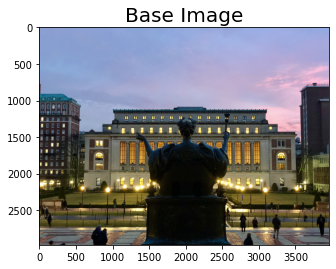

In [ ]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(base_image_path)
plt.imshow(img1)

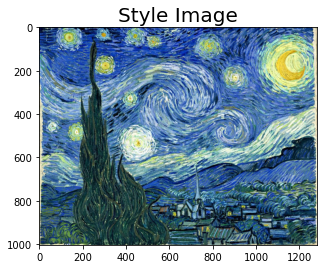

In [ ]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(style_image_path)
plt.imshow(img1)

In [ ]:
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

In [ ]:
K.image_data_format()


'channels_last'

In [ ]:
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [ ]:
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

The following Variables were used a Lambda layer's call (tf.concat), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(1, 400, 533, 3) dtype=float32>
  <tf.Variable 'Variable:0' shape=(1, 400, 533, 3) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [ ]:
from keras.applications.vgg19 import VGG19
vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights='imagenet')
#model = vgg19.VGG19(input_tensor=input_tensor,
#                    weights='imagenet', include_top=False)
print('Model loaded.')

80142336/80134624 [==============================] - 1s 0us/step
Model loaded.


In [ ]:
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

KerasTensor(type_spec=TensorSpec(shape=(3, 25, 33, 512), dtype=tf.float32, name=None), name='block5_conv2/Relu:0', description="created by layer 'block5_conv2'")


In [ ]:
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

In [ ]:
import tensorflow as tf
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    #if K.image_data_format() == 'channels_first':
    #    features = K.batch_flatten(input_tensor)
    #else:
    #    features = K.batch_flatten(K.permute_dimensions(input_tensor,(2,0,1)))
    #gram = K.dot(features, K.transpose(features))
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))#/(4.0 * (channels ** 2) * (size ** 2))

In [ ]:
def watch_layer(layer, tape):
    """
    Make an intermediate hidden `layer` watchable by the `tape`.
    After calling this function, you can obtain the gradient with
    respect to the output of the `layer` by calling:

        grads = tape.gradient(..., layer.result)

    """
    def decorator(func):
        def wrapper(*args, **kwargs):
            # Store the result of `layer.call` internally.
            layer.result = func(*args, **kwargs)
            # From this point onwards, watch this tensor.
            tape.watch(layer.result)
            # Return the result to continue with the forward pass.
            return layer.result
        return wrapper
    layer.call = decorator(layer.call)
    return layer

In [ ]:
from keras.layers import Input, Lambda
from keras.models import Model

content_weight=0.025 
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')


loss = loss + content_weight * get_content_loss(base_image_features,combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                    'block3_conv1', 'block4_conv1',
                    'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl

Layer Feature for Content Layers :: KerasTensor(type_spec=TensorSpec(shape=(3, 25, 33, 512), dtype=tf.float32, name=None), name='block5_conv2/Relu:0', description="created by layer 'block5_conv2'")
Base Image Feature :: KerasTensor(type_spec=TensorSpec(shape=(25, 33, 512), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")
Combination Image Feature for Content Layers:: KerasTensor(type_spec=TensorSpec(shape=(25, 33, 512), dtype=tf.float32, name=None), name='tf.__operators__.getitem_1/strided_slice:0', description="created by layer 'tf.__operators__.getitem_1'")

Layer Feature for Style Layers :: KerasTensor(type_spec=TensorSpec(shape=(3, 400, 533, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
Style Image Feature :: KerasTensor(type_spec=TensorSpec(shape=(400, 533, 64), dtype=tf.float32, name=None), name='tf.__operators__.getitem_2/stride

In [ ]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
tf.compat.v1.disable_eager_execution()
grads = K.gradients(loss,combination_image)
grads

TypeError: ignored

In [ ]:
with tf.GradientTape() as gtape:
  tf.compat.v1.disable_eager_execution()
  grads = gtape.gradient(loss, combination_image)
grads

AttributeError: ignored

In [ ]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs = outputs+grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

ValueError: ignored